# Leave-simulation-out

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import sys
import matplotlib.pyplot as plt

from forestflow.model_p3d_arinyo import ArinyoModel
from forestflow.archive import GadgetArchive3D
from forestflow.P3D_cINN import P3DEmulator
from forestflow.plots.l1O_p3d import plot_p3d_L1O
from forestflow.plots.l1O_p1d import plot_p1d_L1O

from matplotlib import rcParams

rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"


## DEFINE FUNCTIONS

In [2]:
def ls_level(folder, nlevels):
    for ii in range(nlevels):
        folder = os.path.dirname(folder)
    folder += "/"
    return folder


path_program = ls_level(os.getcwd(), 1)
print(path_program)
sys.path.append(path_program)

/home/jchaves/Proyectos/projects/lya/ForestFlow/


# LOAD DATA

In [3]:
%%time
folder_interp = path_program + "/data/plin_interp/"
folder_lya_data = path_program + "/data/best_arinyo/"

Archive3D = GadgetArchive3D(
    base_folder=path_program,
    folder_data=folder_lya_data,
    force_recompute_plin=False,
    average="both",
)
print(len(Archive3D.training_data))

1650
CPU times: user 22.1 s, sys: 691 ms, total: 22.8 s
Wall time: 22.9 s


In [4]:
Nsim = 30
Nz = 11
zs = np.flip(np.arange(2, 4.6, 0.25))

k_Mpc = Archive3D.training_data[0]["k3d_Mpc"]
mu = Archive3D.training_data[0]["mu3d"]

k_mask = (k_Mpc < 4) & (k_Mpc > 0)

k_Mpc = k_Mpc[k_mask]
mu = mu[k_mask]

k_p1d_Mpc = Archive3D.training_data[0]["k_Mpc"]
k1d_mask = (k_p1d_Mpc < 5) & (k_p1d_Mpc > 0)
k_p1d_Mpc = k_p1d_Mpc[k1d_mask]
norm = k_p1d_Mpc / np.pi

## LEAVE ONE OUT TEST

In [5]:
p3ds_pred = np.zeros(shape=(Nsim, Nz, k_Mpc.shape[0]))
p1ds_pred = np.zeros(shape=(Nsim, Nz, k_p1d_Mpc.shape[0]))

p3ds_arinyo = np.zeros(shape=(Nsim, Nz, k_Mpc.shape[0]))
p1ds_arinyo = np.zeros(shape=(Nsim, Nz, k_p1d_Mpc.shape[0]))

p3ds_sims = np.zeros(shape=(Nsim, Nz, k_Mpc.shape[0]))
p1ds_sims = np.zeros(shape=(Nsim, Nz, k_p1d_Mpc.shape[0]))

for s in range(Nsim):
    print(f"Starting simulation {s}")

    training_data = [
        d for d in Archive3D.training_data if d["sim_label"] != f"mpg_{s}"
    ]

    p3d_emu = P3DEmulator(
        training_data,
        Archive3D.emu_params,
        nepochs=1,
        lr=0.001,  # 0.005
        batch_size=20,
        step_size=200,
        gamma=0.1,
        weight_decay=0,
        adamw=True,
        nLayers_inn=12,  # 15
        Archive=Archive3D,
        model_path=f"../data/emulator_models/mpg_drop{s}.pt",
    )

    for iz, z in enumerate(zs):
        # load arinyo module
        flag = f"Plin_interp_sim{s}.npy"
        file_plin_inter = folder_interp + flag
        pk_interp = np.load(file_plin_inter, allow_pickle=True).all()
        model_Arinyo = ArinyoModel(camb_pk_interp=pk_interp)

        # define test sim
        dict_sim = [
            d
            for d in Archive3D.training_data
            if d["z"] == z
            and d["sim_label"] == f"mpg_{s}"
            and d["val_scaling"] == 1
        ]

        # p1d from sim
        p1d_sim, p1d_k = p3d_emu.get_p1d_sim(dict_sim)

        # p3d from sim
        p3d_sim = dict_sim[0]["p3d_Mpc"][p3d_emu.k_mask]
        p3d_sim = np.array(p3d_sim)

        p1ds_sims[s, iz] = p1d_sim
        p3ds_sims[s, iz] = p3d_sim

        # load BF Arinyo and estimated the p3d and p1d from BF arinyo parameters
        out = p3d_emu.predict_P3D_Mpc(
            sim_label=f"mpg_{s}", 
            z=z, 
            emu_params=dict_sim[0],
            kpar_Mpc = k_p1d_Mpc
        )
        # t_keys(['coeffs_Arinyo', 'Plin', 'p3d_cov', 'p3d', 'p1d', 'p1d_cov'])
        BF_arinyo = dict_sim[0]["Arinyo_minin"]

        p3ds_arinyo[s, iz] = model_Arinyo.P3D_Mpc(z, k_Mpc, mu, BF_arinyo)
        p1ds_arinyo[s, iz] = model_Arinyo.P1D_Mpc(z, k_p1d_Mpc, parameters=BF_arinyo) * norm
        
        p3ds_pred[s, iz] = out['p3d']
        p1ds_pred[s, iz] = out['p1d'] * norm

    
    print(
        "Mean fractional error P3D pred to Arinyo",
        ((p3ds_pred[s] / p3ds_arinyo[s] - 1) * 100).mean(),
    )
    print(
        "Std fractional error P3D pre to Arinyo",
        ((p3ds_pred[s] / p3ds_arinyo[s] - 1) * 100).std(),
    )

    print(
        "Mean fractional error P3D Arinyo model",
        ((p3ds_arinyo[s] / p3ds_sims[s] - 1) * 100).mean(),
    )
    print(
        "Std fractional error P3D Arinyo model",
        ((p3ds_arinyo[s] / p3ds_sims[s] - 1) * 100).std(),
    )

    print(
        "Mean fractional error P3D pred to sim",
        ((p3ds_pred[s] / p3ds_sims[s] - 1) * 100).mean(),
    )
    print(
        "Std fractional error P3D pred to sim",
        ((p3ds_pred[s] / p3ds_sims[s] - 1) * 100).std(),
    )

    print(
        "Mean fractional error P1D pred to Arinyo",
        ((p1ds_pred[s] / p1ds_arinyo[s] - 1) * 100).mean(),
    )
    print(
        "Std fractional error P1D pred to Arinyo",
        ((p1ds_pred[s] / p1ds_arinyo[s] - 1) * 100).std(),
    )

    print(
        "Mean fractional error P1D Arinyo model",
        ((p1ds_arinyo[s] / p1ds_sims[s] - 1) * 100).mean(),
    )
    print(
        "Std fractional error P1D Arinyo model",
        ((p1ds_arinyo[s] / p1ds_sims[s] - 1) * 100).std(),
    )

    print(
        "Mean fractional error P1D pred to sim",
        ((p1ds_pred[s] / p1ds_sims[s] - 1) * 100).mean(),
    )
    print(
        "Std fractional error P1D pred to sim",
        ((p1ds_pred[s] / p1ds_sims[s] - 1) * 100).std(),
    )

Starting simulation 0


/home/jchaves/Proyectos/projects/lya/ForestFlow/forestflow/P3D_cINN.py:580: UserWarning: Loading a pre-trained emulator
  warn("Loading a pre-trained emulator")
/home/jchaves/Proyectos/projects/lya/ForestFlow/forestflow/P3D_cINN.py:443: UserWarning: Covariance matrix returned for p3d_arinyo.reshape(-1)
  warn("Covariance matrix returned for p3d_arinyo.reshape(-1)")


Mean fractional error P3D pred to Arinyo 1.5856028796907835
Std fractional error P3D pre to Arinyo 3.5995435191749103
Mean fractional error P3D Arinyo model 0.008748028623703871
Std fractional error P3D Arinyo model 7.269611975779662
Mean fractional error P3D pred to sim 1.5358012148849012
Std fractional error P3D pred to sim 7.529659774353756
Mean fractional error P1D pred to Arinyo 0.5430827087144655
Std fractional error P1D pred to Arinyo 1.6520105217757803
Mean fractional error P1D Arinyo model -0.036170518627006196
Std fractional error P1D Arinyo model 1.3119091535217244
Mean fractional error P1D pred to sim 0.49349497502556955
Std fractional error P1D pred to sim 1.3487120735195142
Starting simulation 1
Mean fractional error P3D pred to Arinyo 1.731695845347179
Std fractional error P3D pre to Arinyo 6.089409690614061
Mean fractional error P3D Arinyo model 1.1872247091911536
Std fractional error P3D Arinyo model 9.553515193374556
Mean fractional error P3D pred to sim 2.59436053472

### L1O of each sim

for ii in range(

## PLOTTING

In [6]:
folder = "/home/jchaves/Proyectos/projects/lya/data/forestflow/figures/"
z_use = np.arange(2, 4.5, 0.5)
z_use

array([2. , 2.5, 3. , 3.5, 4. ])

#### P3D

In [48]:
fractional_errors_arinyo = (p3ds_pred / p3ds_arinyo -1)
fractional_errors_sims = (p3ds_pred / p3ds_sims -1)
fractional_errors_bench = (p3ds_arinyo / p3ds_sims -1)

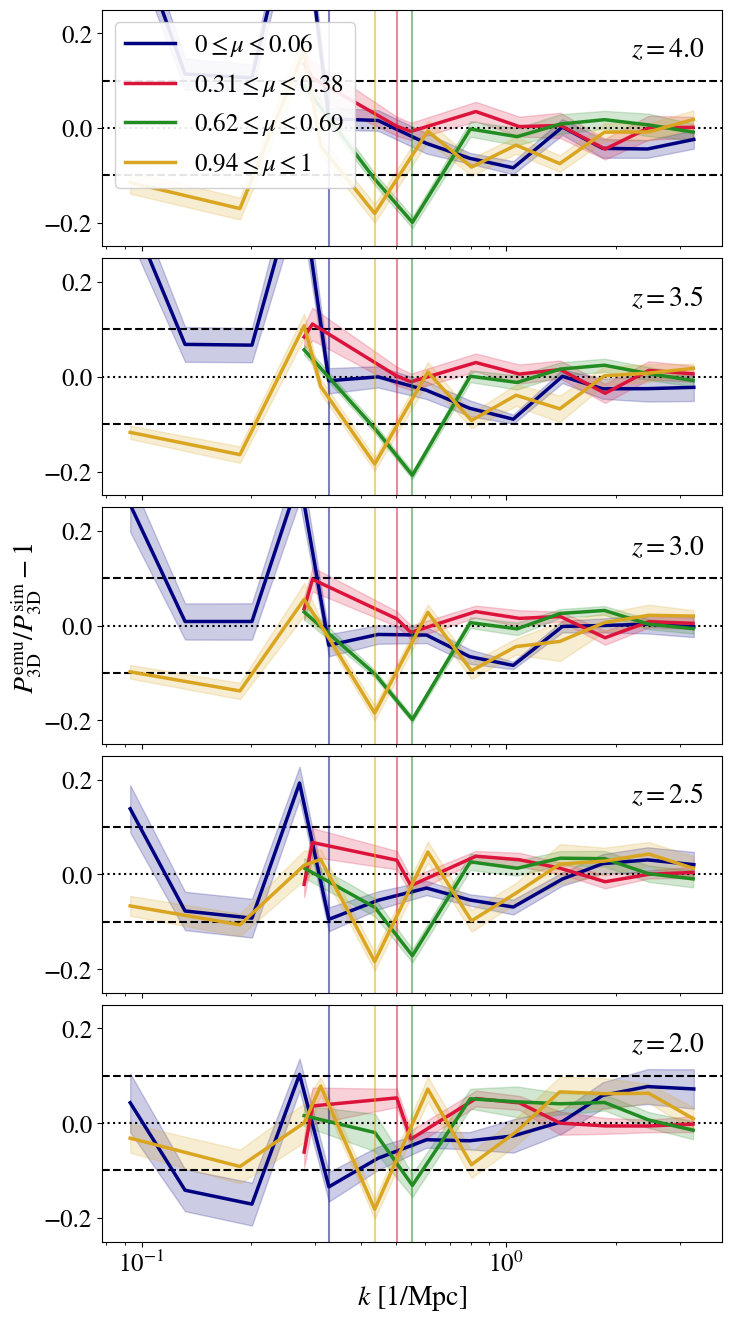

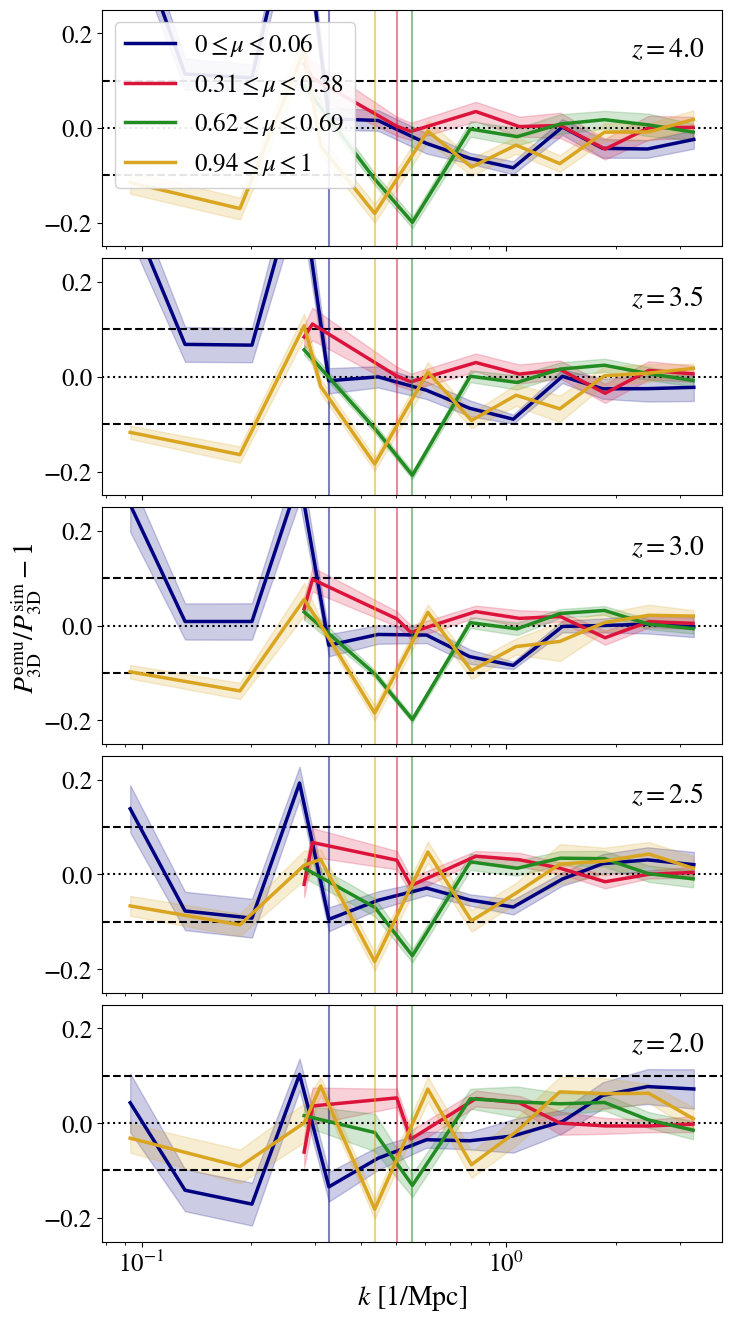

In [60]:
# plot_p3d_L1O(Archive3D, z_use, fractional_errors_sims)
plot_p3d_L1O(Archive3D, z_use, fractional_errors_sims, savename=folder+"l1O/l1O_P3D.png");
plot_p3d_L1O(Archive3D, z_use, fractional_errors_sims, savename=folder+"l1O/l1O_P3D.pdf");

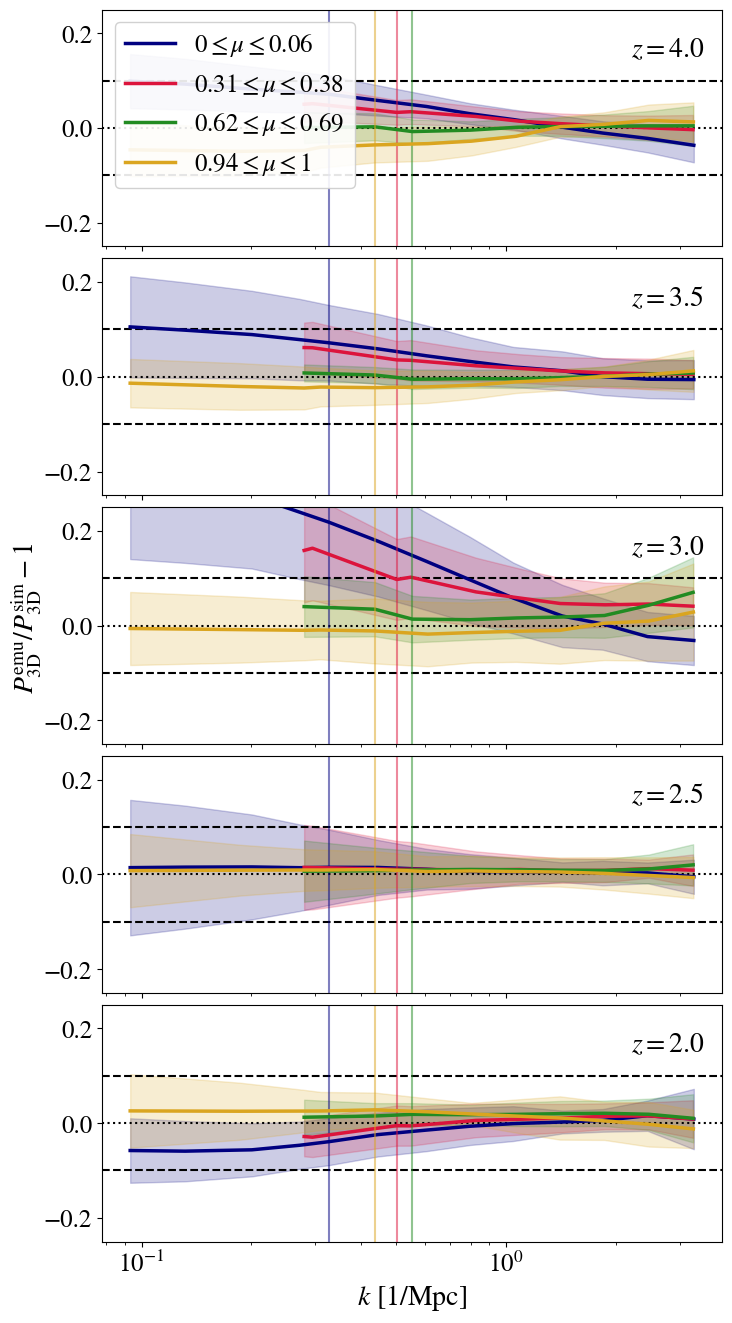

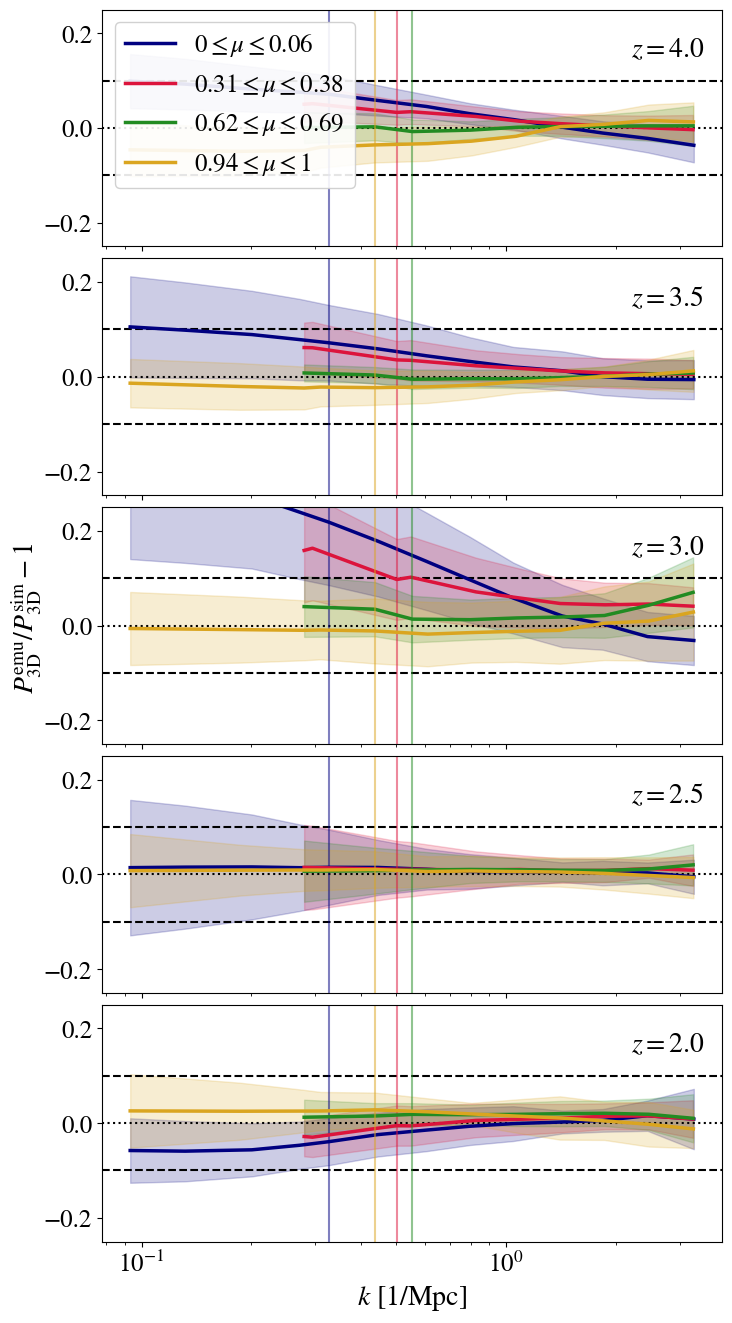

In [51]:
# plot_p3d_L1O(Archive3D, z_use, fractional_errors_arinyo)
plot_p3d_L1O(Archive3D, z_use, fractional_errors_arinyo, savename=folder+"l1O/l1O_P3D_smooth.png");
plot_p3d_L1O(Archive3D, z_use, fractional_errors_arinyo, savename=folder+"l1O/l1O_P3D_smooth.pdf");

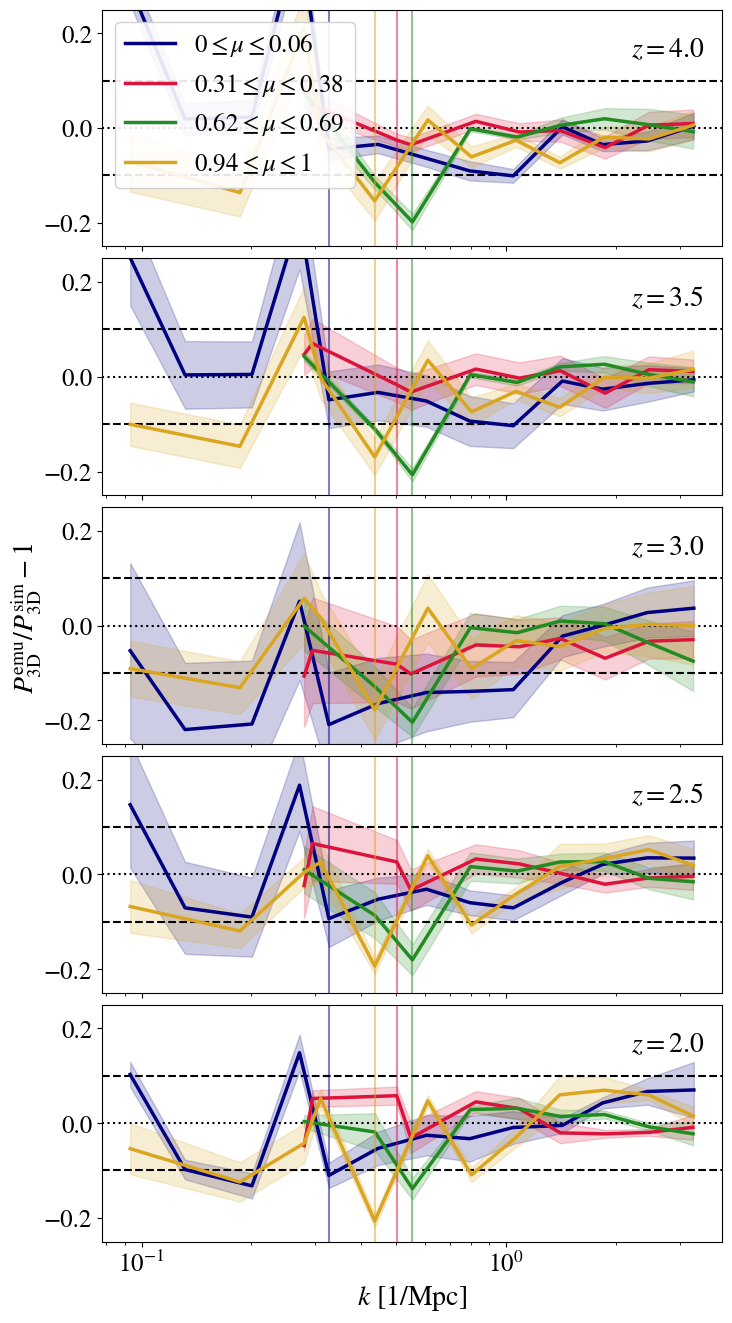

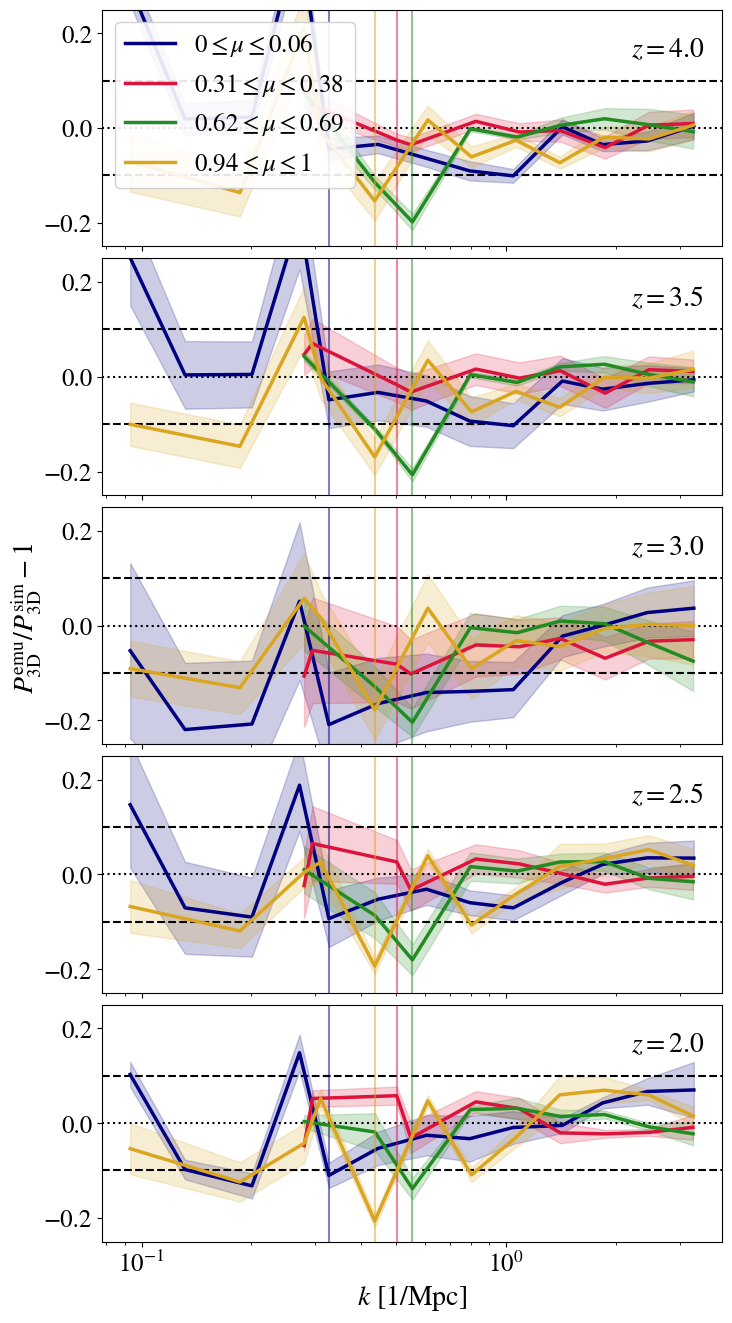

In [52]:
# plot_p3d_L1O(Archive3D, z_use, fractional_errors_bench)
plot_p3d_L1O(Archive3D, z_use, fractional_errors_bench, savename=folder+"fit/fit_P3D.png")
plot_p3d_L1O(Archive3D, z_use, fractional_errors_bench, savename=folder+"fit/fit_P3D.pdf")

#### P1D

In [7]:
fractional_errors_arinyo_p1d = (p1ds_pred / p1ds_arinyo - 1)
fractional_errors_sims_p1d = (p1ds_pred / p1ds_sims - 1)
fractional_errors_bench_p1d = (p1ds_arinyo / p1ds_sims - 1)

In [17]:
# plot_p1d_L1O(Archive3D, z_use, fractional_errors_sims_p1d)

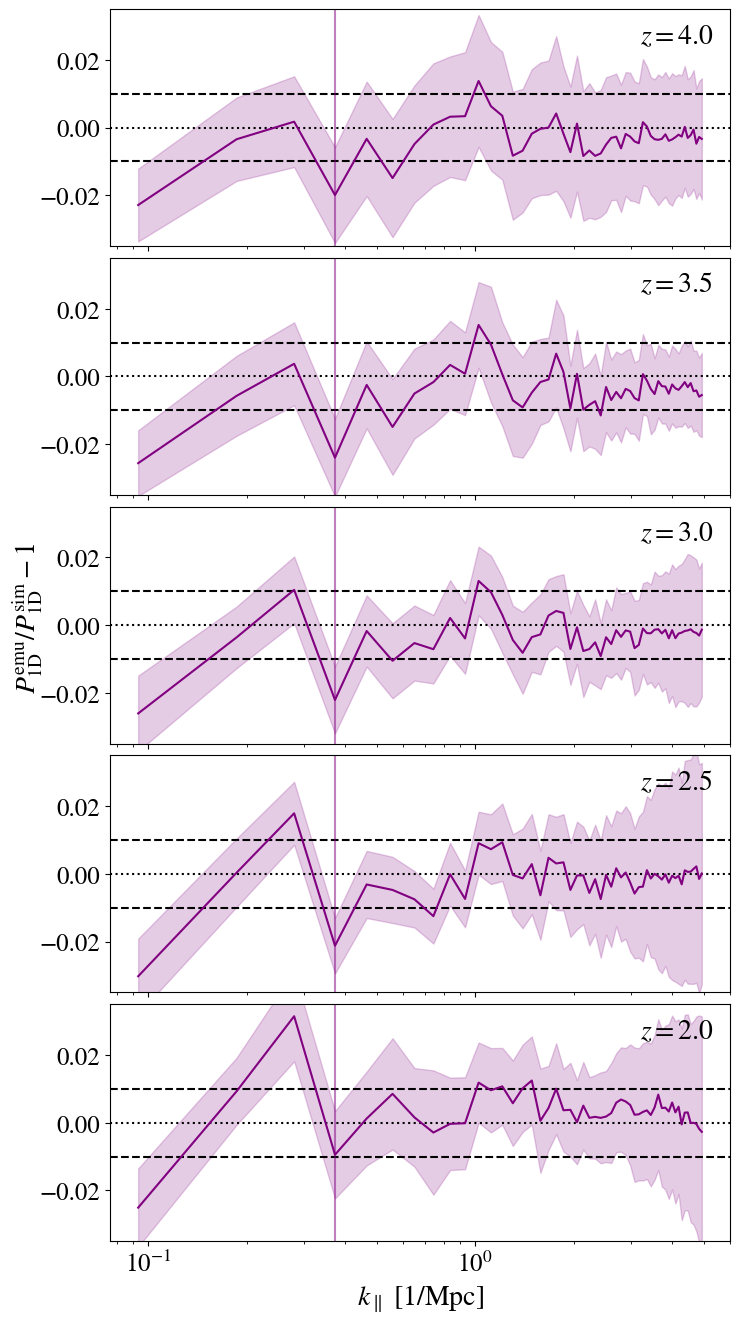

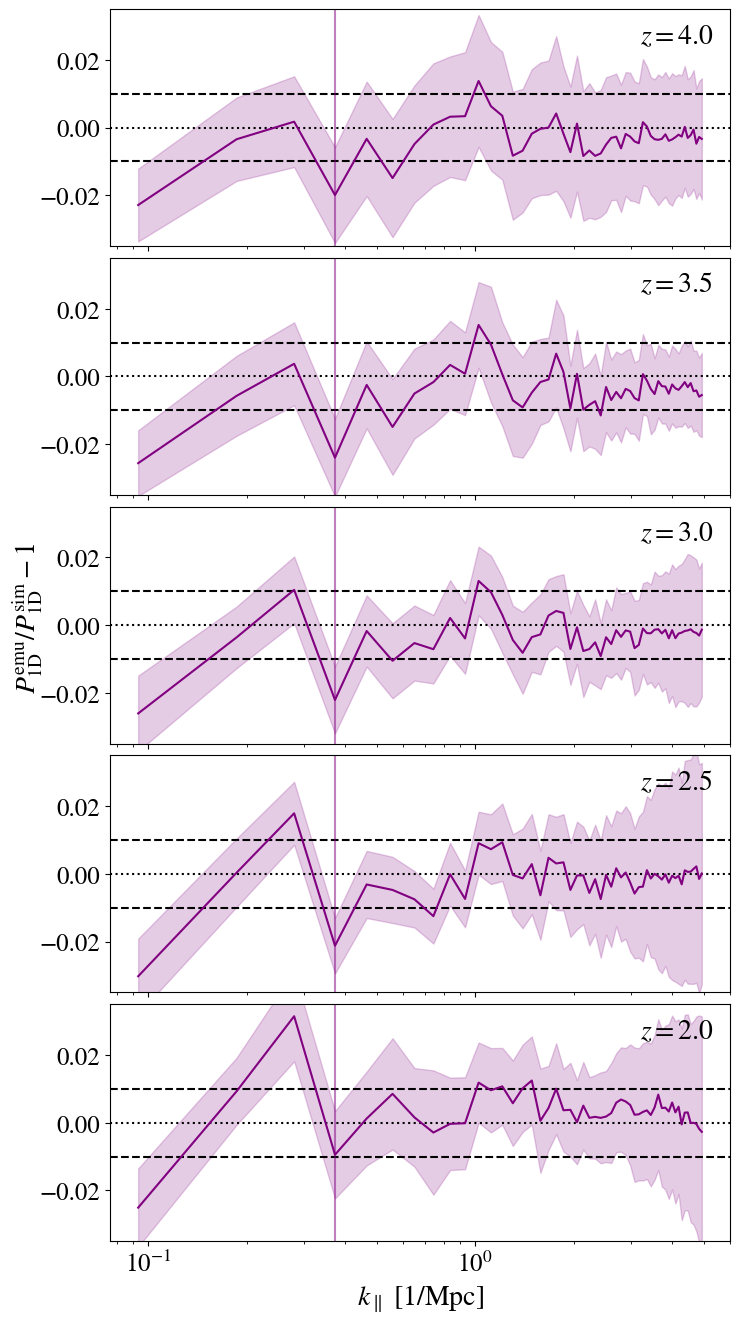

In [19]:
# plot_p1d_L1O(Archive3D, z_use, fractional_errors_sims_p1d)
plot_p1d_L1O(Archive3D, z_use, fractional_errors_sims_p1d, savename=folder+"l1O/l1O_P1D.png")
plot_p1d_L1O(Archive3D, z_use, fractional_errors_sims_p1d, savename=folder+"l1O/l1O_P1D.pdf")

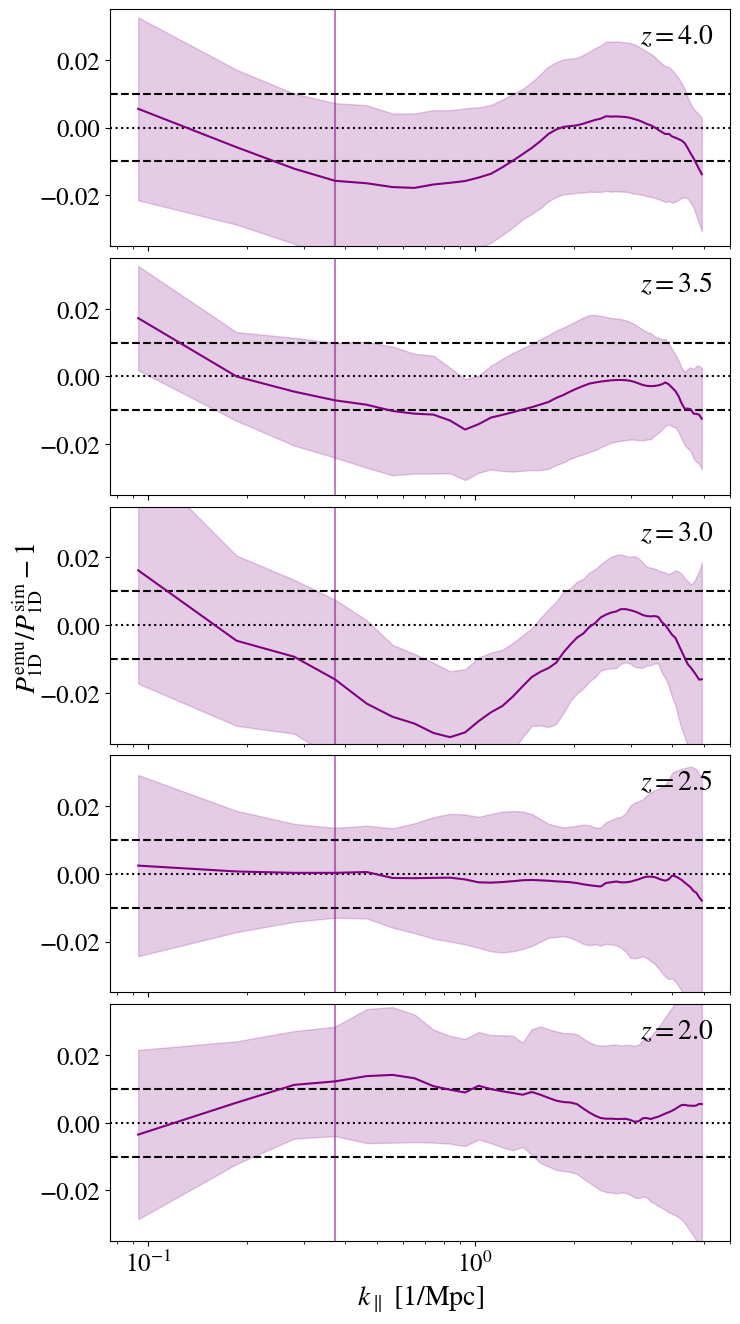

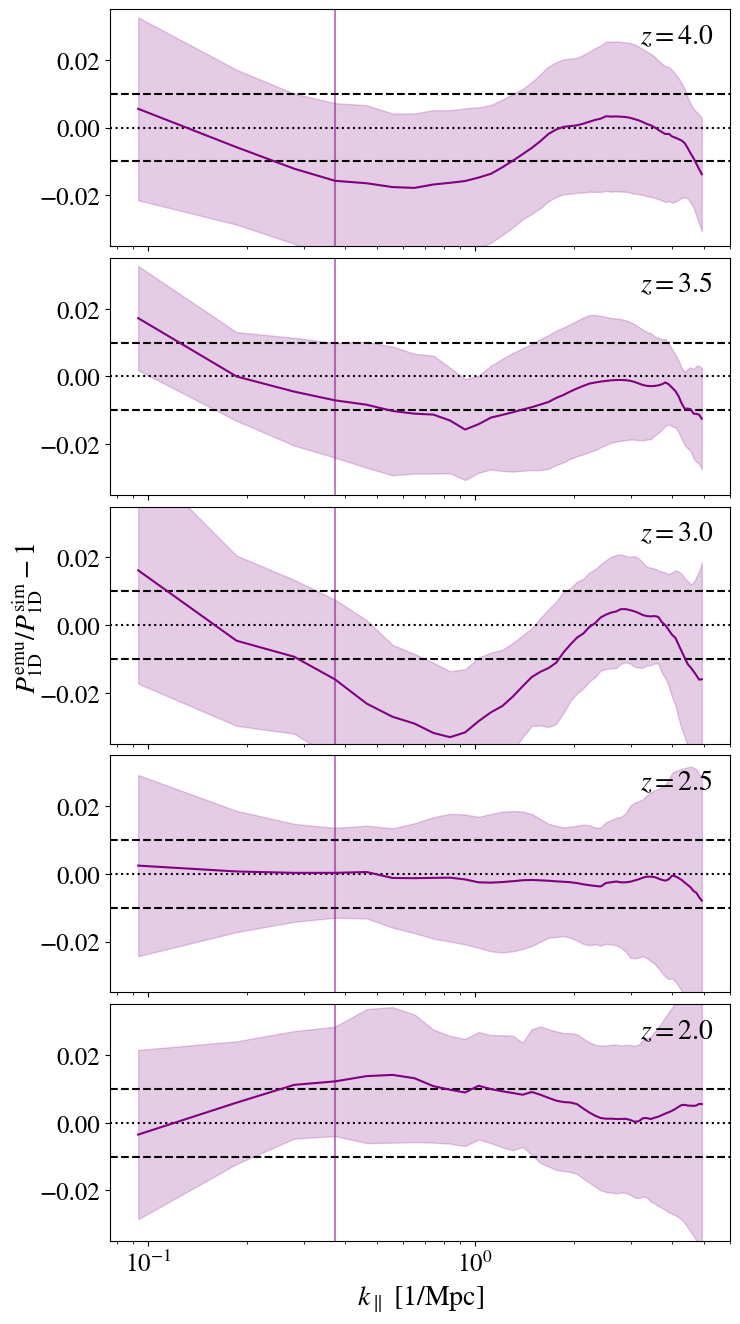

In [20]:
# plot_p1d_L1O(Archive3D, z_use, fractional_errors_arinyo_p1d)
plot_p1d_L1O(Archive3D, z_use, fractional_errors_arinyo_p1d, savename=folder+"l1O/l1O_P1D_smooth.pdf")
plot_p1d_L1O(Archive3D, z_use, fractional_errors_arinyo_p1d, savename=folder+"l1O/l1O_P1D_smooth.png")

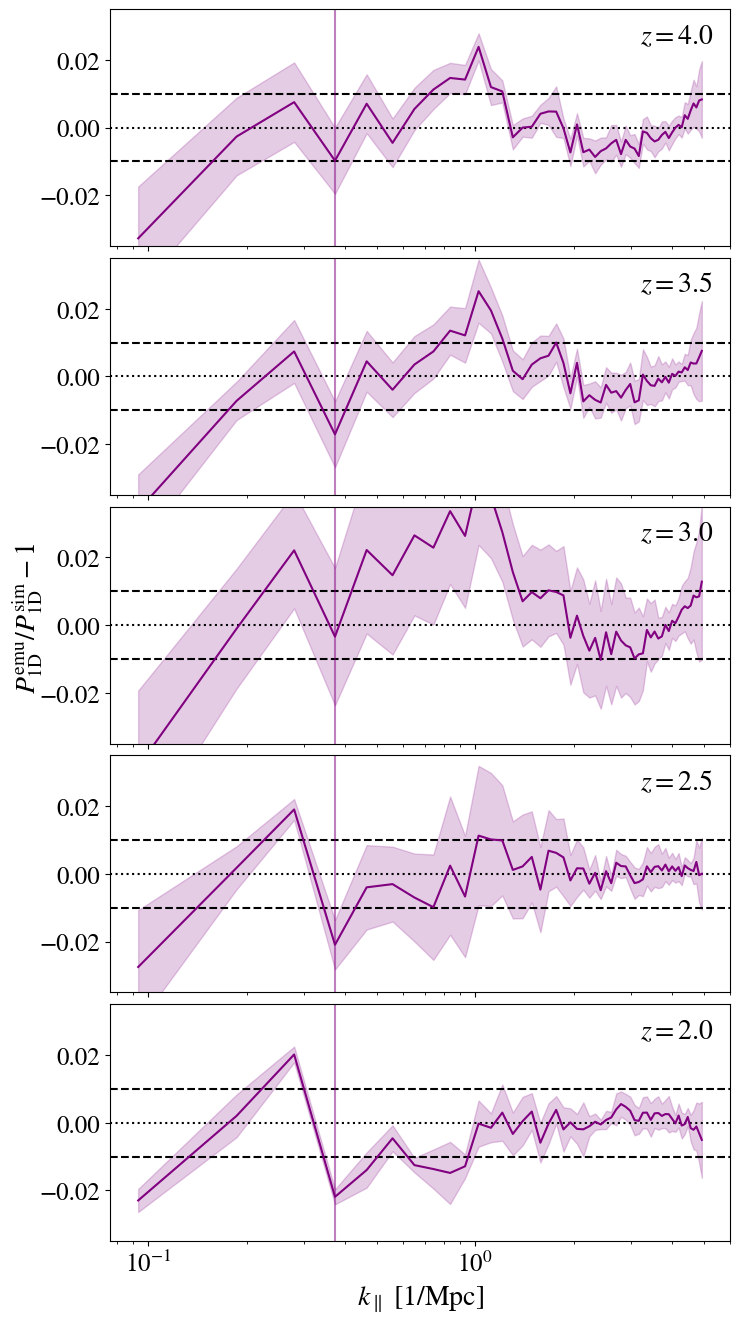

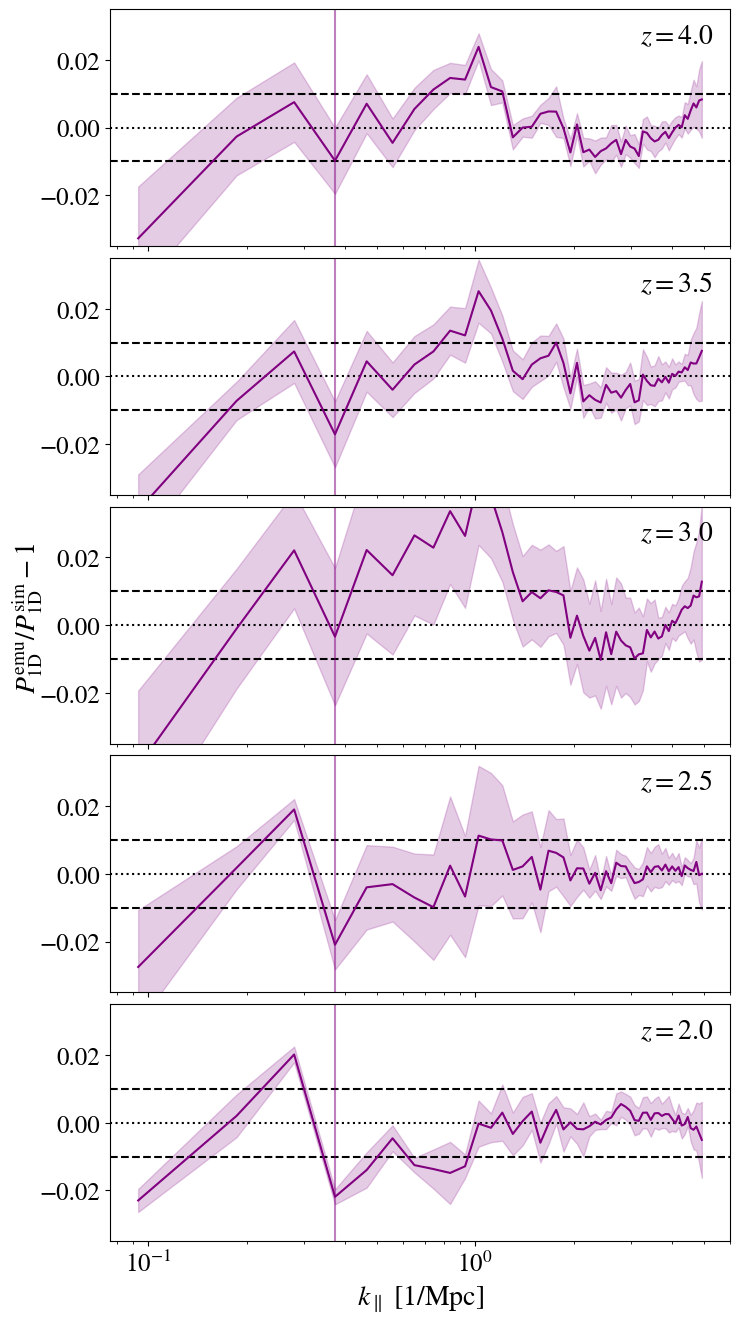

In [21]:
# plot_p1d_L1O(Archive3D, z_use, fractional_errors_bench_p1d)
plot_p1d_L1O(Archive3D, z_use, fractional_errors_bench_p1d, savename=folder+"fit/fit_P1D.png")
plot_p1d_L1O(Archive3D, z_use, fractional_errors_bench_p1d, savename=folder+"fit/fit_P1D.pdf")